In [54]:
# Imports:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# load data set
test_data = pd.read_csv("test.csv")
train_data = pd.read_csv("train.csv")

In [3]:
test_data.head()

,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,...,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,1,1043,1,1.8,1,14,0,5,0.1,193,...,16,226,1412,3476,12,7,2,0,1,0
1,2,841,1,0.5,1,4,1,61,0.8,191,...,12,746,857,3895,6,0,7,1,0,0
2,3,1807,1,2.8,0,1,0,27,0.9,186,...,4,1270,1366,2396,17,10,10,0,1,1
3,4,1546,0,0.5,1,18,1,25,0.5,96,...,20,295,1752,3893,10,0,7,1,1,0
4,5,1434,0,1.4,0,11,1,49,0.5,108,...,18,749,810,1773,15,8,7,1,0,1


In [4]:
train_data.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

<AxesSubplot:xlabel='price_range', ylabel='count'>

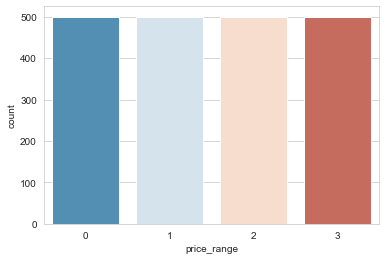

In [8]:
# counts of price_range
sns.set_style('whitegrid')
sns.countplot(x='price_range',data=train_data,palette='RdBu_r')

In [11]:
#get correlations of each features in dataset
corrmat = train_data.corr()

#print and sort correlations
correlations = train_data.corr()['price_range'].dropna().sort_values()
print(correlations)

touch_screen    -0.030411
mobile_wt       -0.030302
clock_speed     -0.006606
m_dep            0.000853
n_cores          0.004399
four_g           0.014772
dual_sim         0.017444
wifi             0.018785
blue             0.020573
talk_time        0.021859
fc               0.021998
sc_h             0.022986
three_g          0.023611
pc               0.033599
sc_w             0.038711
int_memory       0.044435
px_height        0.148858
px_width         0.165818
battery_power    0.200723
ram              0.917046
price_range      1.000000
Name: price_range, dtype: float64


<AxesSubplot:>

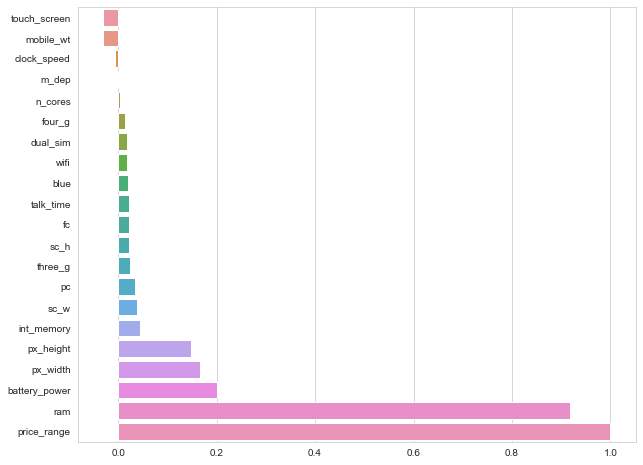

In [28]:
# Plot coorelations
plt.figure(figsize=(10, 8))
sns.barplot(correlations.values, correlations.index)

In [29]:
#splitting the dataset for chi-square test
X = train_data.drop('price_range',axis=1)
y = train_data['price_range']
print(X.shape)
print(y.shape)

(2000, 20)
(2000,)


In [32]:
chi_scores = chi2(X,y)
chi_scores

(array([1.41298666e+04, 7.23232323e-01, 6.48365906e-01, 6.31010795e-01,
        1.01351665e+01, 1.52157239e+00, 8.98391244e+01, 7.45819631e-01,
        9.59728626e+01, 9.09755558e+00, 9.18605355e+00, 1.73635695e+04,
        9.81058675e+03, 9.31267519e+05, 9.61487832e+00, 1.64803191e+01,
        1.32364000e+01, 3.27642810e-01, 1.92842942e+00, 4.22090730e-01]),
 array([0.00000000e+00, 8.67726342e-01, 8.85276201e-01, 8.89297893e-01,
        1.74514323e-02, 6.77300459e-01, 2.37197834e-19, 8.62377379e-01,
        1.14084978e-20, 2.80215610e-02, 2.69167984e-02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.21401351e-02, 9.03765912e-04,
        4.15229208e-03, 9.54748475e-01, 5.87393502e-01, 9.35642196e-01]))

<AxesSubplot:>

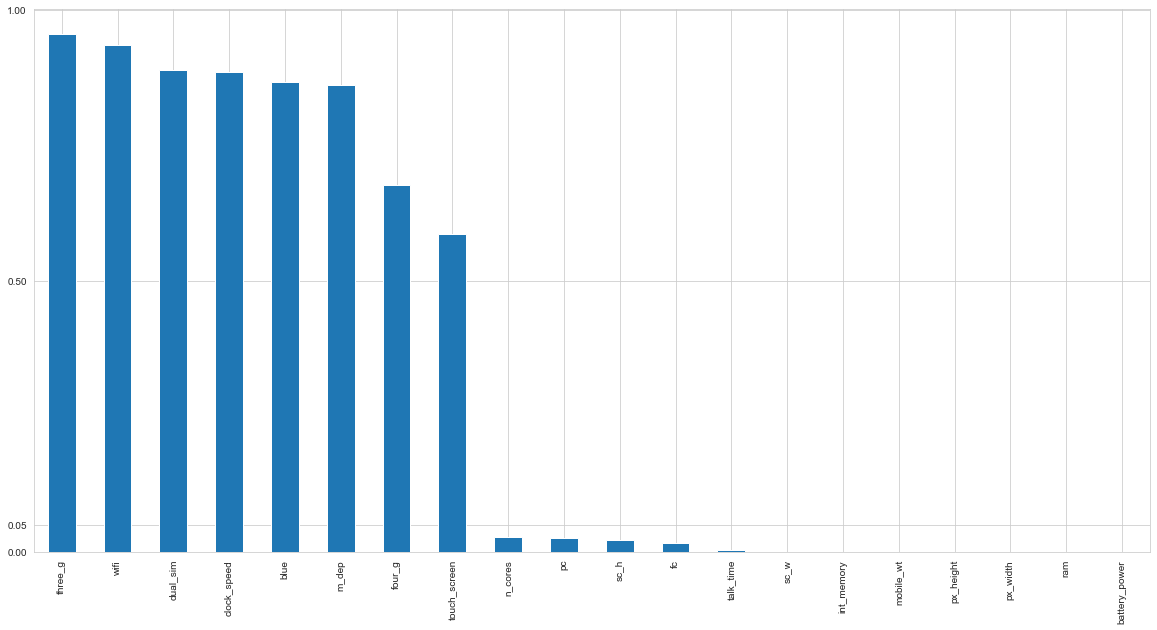

In [39]:
#plotting the p-values
plt.figure(figsize=(20,10))
plt.yticks((0, 0.05, 0.5, 1))
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)
p_values.plot.bar()

In [43]:
X = train_data.drop(['price_range','three_g','wifi','dual_sim','clock_speed','blue','m_dep','four_g','touch_screen'], axis=1)
y = train_data["price_range"]
X_train,X_test,y_train,y_test=train_test_split(X, y, train_size=0.8, stratify = y, random_state=100)

In [44]:
#shape of dataset
y_train.shape, y_test.shape

((1600,), (400,))

In [45]:
#actual dataset ratio of for each class in training set
y_train.value_counts()/len(y_train)

3    0.25
2    0.25
1    0.25
0    0.25
Name: price_range, dtype: float64

In [48]:
#Provide a dictionary of these values to test
param_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [49]:
#Instantiate object
grid = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = param_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [50]:
#Fit to find the best combo of params
grid.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.2min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [51]:
#Show the best params to use
grid.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 40,
 'bootstrap': False}

In [52]:
#New predictions
grid_predictions = grid.predict(X_test)

In [55]:
#Print reports
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))

[[99  1  0  0]
 [ 7 88  5  0]
 [ 0 13 81  6]
 [ 0  0  5 95]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       100
           1       0.86      0.88      0.87       100
           2       0.89      0.81      0.85       100
           3       0.94      0.95      0.95       100

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400



## Re-run for entire training set before running on test set

In [56]:
# Re-run using best estimation of features
rfc_full = RandomForestClassifier(n_estimators=200,
                                  min_samples_split=5,
                                  min_samples_leaf=2,
                                  max_features='sqrt',
                                  max_depth=40,
                                  bootstrap=False)

#Fit model
rfc_full.fit(X,y)

RandomForestClassifier(bootstrap=False, max_depth=40, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200)

In [63]:
#Run on the test dataframe
full_predictions = rfc_full.predict(test_data.drop(['id','three_g','wifi','dual_sim','clock_speed','blue','m_dep','four_g','touch_screen'], axis=1))

In [64]:
full_predictions

array([3, 3, 2, 3, 1, 3, 3, 1, 3, 0, 3, 3, 0, 0, 2, 0, 2, 1, 3, 2, 1, 3,
       1, 1, 3, 0, 2, 0, 2, 0, 2, 0, 3, 0, 0, 1, 3, 1, 2, 1, 1, 2, 0, 0,
       0, 1, 0, 3, 1, 2, 1, 0, 3, 0, 3, 1, 3, 1, 1, 3, 3, 2, 0, 1, 1, 1,
       1, 3, 1, 2, 1, 2, 2, 3, 3, 0, 2, 0, 2, 3, 0, 3, 3, 0, 3, 0, 3, 1,
       3, 0, 1, 2, 2, 0, 2, 1, 0, 2, 1, 2, 1, 0, 0, 3, 1, 2, 0, 1, 2, 3,
       3, 3, 1, 3, 3, 3, 3, 1, 3, 0, 0, 3, 2, 1, 2, 0, 3, 2, 3, 1, 0, 2,
       1, 1, 3, 1, 1, 0, 3, 2, 1, 3, 1, 3, 2, 3, 3, 2, 2, 3, 2, 3, 0, 0,
       2, 2, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 1, 0, 3, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 2, 0, 0, 0, 1, 2, 2, 2, 1, 0, 0, 0, 1, 0, 3, 2, 0, 2, 2,
       2, 3, 1, 2, 3, 3, 3, 1, 2, 1, 0, 0, 1, 3, 0, 2, 3, 3, 0, 2, 0, 3,
       2, 2, 3, 0, 0, 1, 0, 3, 0, 1, 0, 2, 2, 1, 3, 0, 2, 0, 3, 1, 2, 0,
       0, 2, 1, 3, 3, 3, 1, 1, 3, 0, 0, 2, 3, 3, 1, 3, 1, 1, 3, 2, 1, 2,
       3, 3, 3, 1, 0, 1, 2, 3, 1, 1, 3, 2, 0, 3, 0, 1, 2, 0, 0, 3, 2, 3,
       3, 2, 1, 3, 3, 2, 3, 2, 2, 1, 2, 0, 2, 3, 1,

In [65]:
#Merge into final dataframe
pred_df = pd.DataFrame(full_predictions)
test_id = test_data['id']

#Drop indexes (can cause NaN when using Concat if you don't do this beforehand)
pred_df.reset_index(drop=True, inplace=True)
test_id.reset_index(drop=True, inplace=True)

submission = pd.concat([test_id.iloc[0:],pred_df], axis=1)
submission.columns=['id','price_range']
#submission.to_csv('submission.csv', index = False)

<AxesSubplot:xlabel='price_range', ylabel='count'>

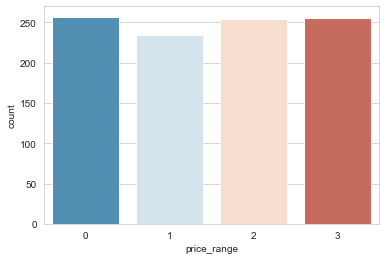

In [68]:
sns.countplot(x='price_range',data=submission,palette='RdBu_r')